In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# All skl imports go here
from sklearn import tree   # Decision Trees
from sklearn import svm    # svm
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import metrics

import sklearn as skl

from neuralnet import NeuralNetwork

# Data Loading

In [2]:
# Load all data
train_data = pd.read_csv("training_labse.csv")
test_data = pd.read_csv("test_labse.csv")
validation_data = pd.read_csv("validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

In [3]:
# Perform pre-processing PCA on the training set
TARGET_EXPLAINED_VARIANCE = 0.95 

def perform_pca(dataset):
    pca = PCA(n_components= TARGET_EXPLAINED_VARIANCE)

    # Need to standardize the data frirst
    standardized = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)

    pca.fit(X=standardized)
    dataset_reduced = pca.fit_transform(X=standardized)

    return pca, dataset_reduced



In [4]:
pca_train, X_train_reduced = perform_pca(X_train)
pca_tran_val, X_train_val_reduced = perform_pca(X_train_val)

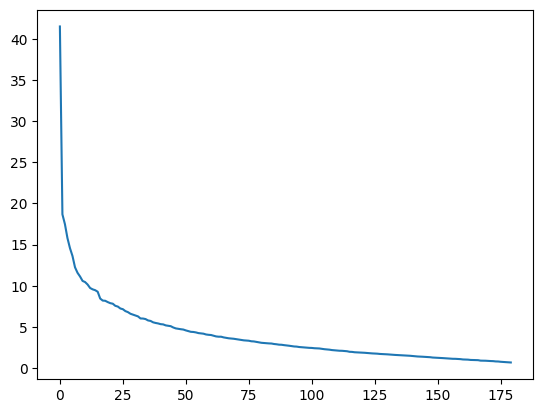

In [6]:
plt.plot(pca_train.explained_variance_)

# K-Folds Cross Validation

In [26]:

def k_folds_x_val(model): 
    cumulative_accuracy = 0
    cumulative_f1 = 0
    cumulative_kappa = 0

    k_folds = KFold(n_splits=10)

    for i, (train_index, test_index) in enumerate(k_folds.split(X_train_val_reduced, Y_train_val)):
        model.fit(X_train_val_reduced[train_index], Y_train_val.iloc[train_index])
        
        Y_pred = model.predict(X_train_val_reduced[test_index])
        Y_true = Y_train_val.iloc[test_index]
        # Add all metrics here

        cumulative_accuracy += metrics.accuracy_score(Y_true, Y_pred)
        cumulativve_f1 += metrics.f1_score(Y_true, Y_pred)
        cumulative_kappa += metrics.cohen_kappa_score(Y_true, Y_pred)

    folds = k_folds.get_n_splits()
    print(f"Performed {folds}-fold cross validation")
    print(f"Average accuracy {cumulative_accuracy / folds}")
    print(f"Average F1-score {cumulative_f1 / folds}")
    print(f"Average Kappa {cumulative_kappa / folds}")


# Decision Trees

In [7]:
decision_tree_model = tree.DecisionTreeClassifier(
    criterion='entropy', 
    splitter = 'best',
    max_depth = 5
)

In [8]:
k_folds_x_val(decision_tree_model)

NameError: name 'k_folds_x_val' is not defined

[Text(0.5, 0.9166666666666666, 'x[2] <= -0.23\nentropy = 2.272\nsamples = 16000\nvalue = [4666, 5362, 1304, 2159, 1937, 572]'),
 Text(0.25, 0.75, 'x[3] <= -0.747\nentropy = 2.131\nsamples = 7717\nvalue = [1531, 3666, 810, 711, 677, 322]'),
 Text(0.125, 0.5833333333333334, 'x[5] <= 2.122\nentropy = 2.287\nsamples = 3484\nvalue = [1079, 1070, 249, 495, 451, 140]'),
 Text(0.0625, 0.4166666666666667, 'x[0] <= -6.003\nentropy = 2.299\nsamples = 2709\nvalue = [940, 653, 169, 436, 394, 117]'),
 Text(0.03125, 0.25, 'x[15] <= 0.01\nentropy = 2.051\nsamples = 981\nvalue = [470, 77, 35, 196, 163, 40]'),
 Text(0.015625, 0.08333333333333333, 'entropy = 2.161\nsamples = 413\nvalue = [147, 33, 10, 80, 120, 23]'),
 Text(0.046875, 0.08333333333333333, 'entropy = 1.849\nsamples = 568\nvalue = [323, 44, 25, 116, 43, 17]'),
 Text(0.09375, 0.25, 'x[2] <= -2.854\nentropy = 2.309\nsamples = 1728\nvalue = [470, 576, 134, 240, 231, 77]'),
 Text(0.078125, 0.08333333333333333, 'entropy = 2.225\nsamples = 869\nva

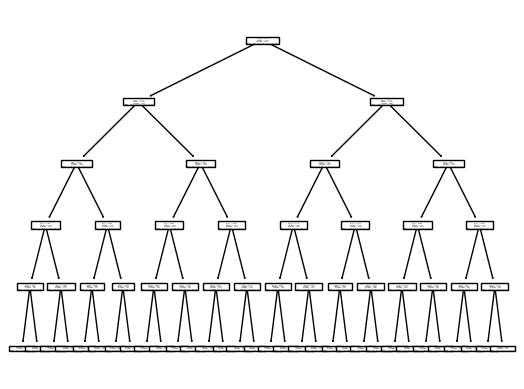

In [9]:
decision_tree_model.fit(X_train_reduced, Y_train)
tree.plot_tree(decision_tree_model)

# SVMs

In [11]:
svm_classifier = svm.SVC(kernel='sigmoid') # 'precomputed', 'linear', 'poly', 'sigmoid', 'rbf'

#Train the model using the training sets
svm_classifier.fit(X_train_reduced, Y_train)

#Predict the response for test dataset
Y_pred = svm_classifier.predict(X_test)

c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


ValueError: X has 768 features, but SVC is expecting 180 features as input.

In [46]:

print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
# Linear = 0.64
# rbf = 0.659
# poly = 0.662
# sigmoid = 0.6235


Accuracy: 0.6235


# MLP

# RNN

# Encoder-Only Transformer

# Test

In [ ]:
model_to_test = decision_tree_model

In [ ]:
#TODO: Add stuff for running the test set on the model